<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Background-info" data-toc-modified-id="Background-info-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Background info</a></span></li><li><span><a href="#Let's-process-a-sample-session" data-toc-modified-id="Let's-process-a-sample-session-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Let's process a sample session</a></span><ul class="toc-item"><li><span><a href="#Extract-useful-task-event-timestamps" data-toc-modified-id="Extract-useful-task-event-timestamps-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Extract useful task event timestamps</a></span></li><li><span><a href="#Convert-neural-spike-times-to-useful-spike-trains-and-firing-rates" data-toc-modified-id="Convert-neural-spike-times-to-useful-spike-trains-and-firing-rates-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Convert neural spike times to useful spike trains and firing rates</a></span></li><li><span><a href="#Bandpass-and-chop-LFP" data-toc-modified-id="Bandpass-and-chop-LFP-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Bandpass and chop LFP</a></span></li></ul></li><li><span><a href="#Comparison-to-matlab-outputs" data-toc-modified-id="Comparison-to-matlab-outputs-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Comparison to matlab outputs</a></span></li></ul></div>

# Background info

For each recording session, subjects perform 1000s of trials during which they are presented with one or two pictures and move a manual lever to indicate their preference. Prior to data collection, subjects learn the assocation between 16 pictures and a unique combination of juice reward probability and amount.

<img src="https://github.com/zbalewski/python-ay250-homework/blob/main/final_project/task_illustration.png?raw=true" alt="task illustration" style="height:200px;"/>

As expected, subjects prefer the pictures that give more juice more often. Their choice behavior reflects that their internal valuation of each picture is effectively expected value (probability * amount).

<img src="https://github.com/zbalewski/python-ay250-homework/blob/main/final_project/psychometric_curves.png?raw=true" alt="psychometric curve" style="height:200px;"/>

While the subjects are working, we record spike times from individual neurons and local field potentials. These temporal signals need to be filtered, downsampled, and aligned to task events before more analyses. For this project, I implemented a general pipeline and compared outputs with my previous processing pipeline in matlab.

I'm graduating next week (!) but I'll hand over the repo to other grad students in my lab, who will hopefully continue to build this out into a shared pipeline for the entire lab.

# Let's process a sample session

In [1]:
#!pip install ephyspipeZB

In [2]:
from os.path import join as pjoin
import glob
import matplotlib.pyplot as plt
import numpy as np

import ephyspipe.brain as brain
import ephyspipe.behavior as bhv

# paths for this data...
data_dir = "data_clean"
out_dir = "output"
session = "George00_rec14_01282021"

bhv_fnames = sorted(glob.glob(pjoin(data_dir, session + "*bhv*")))
spk_fname = glob.glob(pjoin(data_dir, session + "*units*"))[0]
lfp_fname = glob.glob(pjoin(data_dir, session + "*LFP*"))[0]

For this demo, I'll limit the analyses to a few channels with some fun neurons:

In [3]:
fun_channels = [107, 110, 112]

## Extract useful task event timestamps

Load the raw behavior files, plus the duplicate event codes sent to the neural data files.

(These files load slowly because they are organized in a complicted/ugly matlab struct. In the future, it would be useful to reformat into something simpler while converting from \*.bhv2 to \*.mat.)

In [4]:
%%time
# load all of the trial information 
bhv_data = bhv.load_raw_bhv(bhv_fnames)

# load duplicate event codes from the neural data
pl2_codes = bhv.load_pl2_codes(spk_fname)  # can also use lfp_fname

data_clean/George00_rec14_01282021-bhv_A.mat
data_clean/George00_rec14_01282021-bhv_B.mat
data_clean/George00_rec14_01282021-bhv_C.mat
CPU times: user 58.9 s, sys: 2.19 s, total: 1min 1s
Wall time: 1min 3s


Extract the timestamp of interesting events, e.g. picture onset (code = 20), selecting the left(23) or right (24) option, etc. 

(Aside from trial start (9) and stop (18) codes, these are unique for each experiment. All we need for the next step is a vector of timestamps, so it should be very flexible for future custom functions.)

In [5]:
# get timestamps for picture onset
code_pictures = 20
sync_pictures_ts = bhv.get_trial_events(bhv_data, 
                                        pl2_codes, 
                                        code_pictures)
ntrials = sync_pictures_ts.shape[0]

Let's make sure these time points make sense. These picture onset timestamps are a proxy for trials over the session.

Trials take \~5 seconds and should span the entire 2 hour session (\~7,200 seconds). In this session, the animal started to loose motivation in the second hour so we should see a drop in the number of trials.

(0.0, 8000.0)

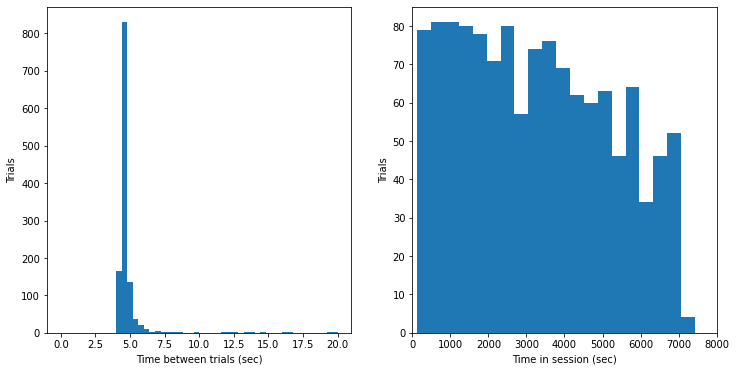

In [6]:
# drop trials that weren't initiated:
keep_trials = sync_pictures_ts > 0

fig = plt.figure(figsize=(12, 6))

# inter trial interval
ax1 = fig.add_subplot(1, 2, 1)
ax1.hist(np.diff(sync_pictures_ts[keep_trials]), bins=50, range=(0, 20))
ax1.set_xlabel("Time between trials (sec)")
ax1.set_ylabel("Trials")

# trial onset distributions
ax2 = fig.add_subplot(1, 2, 2)
ax2.hist(sync_pictures_ts[keep_trials], 20)
ax2.set_xlabel("Time in session (sec)")
ax2.set_ylabel("Trials")
ax2.set_xlim((0, 8000))

While we're looking at the behavior, let's pull out some useful taks information that we can use to analyze our neural data later.

In [7]:
trialinfo = bhv.get_trialinfo(bhv_data)
trialinfo

,trialtype,amnt_left,amnt_right,prob_left,prob_right,value_left,value_right,value_max
0,free,1.0000,5.0000,0.10000,0.36667,0.100000,1.833350,1.833350
1,forced,2.3333,0.0000,0.90000,0.00000,2.099970,0.000000,2.099970
2,free,2.3333,1.0000,0.36667,0.90000,0.855551,0.900000,0.900000
3,free,5.0000,5.0000,0.90000,0.10000,4.500000,0.500000,4.500000
4,forced,0.0000,1.0000,0.00000,0.36667,0.000000,0.366670,0.366670
...,...,...,...,...,...,...,...,...
1412,forced,0.0000,1.0000,0.00000,0.63333,0.000000,0.633330,0.633330
1413,free,2.3333,1.0000,0.10000,0.10000,0.233330,0.100000,0.233330
1414,free,2.3333,1.0000,0.63333,0.90000,1.477749,0.900000,1.477749
1415,forced,0.0000,5.0000,0.00000,0.63333,0.000000,3.166650,3.166650


## Convert neural spike times to useful spike trains and firing rates

For each neuron, we start with spike times (i.e. voltage crossed a 4 st. dev. threshold) over the entire 2 hours session with 40 kHz resolution. We want to convert those to a spike train (0 or 1 to indicate a spike) and smoothed firing rates (50ms boxcar) at 1kHz sampling frequency.

(Note: neurons and units are the same thing. I was inconsistent when writing this code. Sorry for the jargon!)

In [8]:
%%time
spk_train, spk_fr, spk_meta = brain.process_raw_spk(spk_fname, fun_channels)

CPU times: user 1.9 s, sys: 353 ms, total: 2.26 s
Wall time: 2.42 s


These are the neurons we pulled from these channels:

In [9]:
spk_meta

,ID,channel,mean_fr
0,SPK_SPKC107a,107,10.822193
1,SPK_SPKC107b,107,10.028342
2,SPK_SPKC110a,110,1.783157
3,SPK_SPKC112a,112,1.956659
4,SPK_SPKC110aa,110,1.863296
5,SPK_SPKC112aa,112,2.018020


Right now, each neuron corresponds to one row in this giant array (2 hr session, 1 kHz sampling):

In [10]:
print(spk_train.shape)

(6, 7561868)


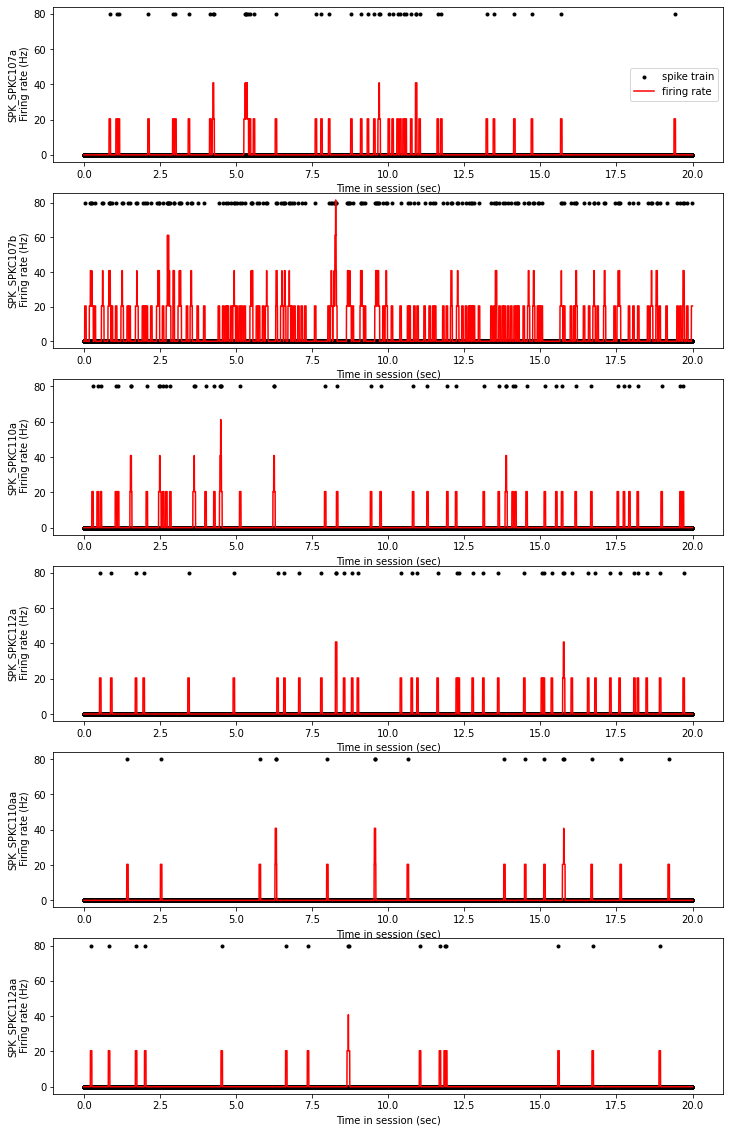

In [11]:
# make sure spike trains and smoothed firing rates are aligned 
# and sensible

nunits = spk_meta.shape[0]  # number of neurons we want to display
ts = np.arange(0, 20, 0.001)  # let's just look at the first 10 seconds 
ntimes = ts.shape[0]

fig = plt.figure(figsize=(12, 20))

for u in range(nunits):
    ax = fig.add_subplot(nunits, 1, u + 1)
    ax.scatter(ts, 80 * spk_train[u, :ntimes], 
               c="k", marker=".")  # scale for vis
    ax.plot(ts, 1000 * spk_fr[u, :ntimes], "r")  # scale to sec 
    
    ax.set_xlabel("Time in session (sec)")
    ax.set_ylabel(spk_meta.ID[u] + "\n Firing rate (Hz)")
    
    if u == 0:
        ax.legend(["spike train", "firing rate"])

Let's chop up this array by the event codes we pulled from the behavior it's in a useful shape for analysis:

    output : 3D np array
        event_sync_points x time_around_event x neurons
    
(Note: A typical session has >1000 trials and >100 neurons and LFP channels, so for loops can get quite slow! Converting this to matrix indexing changed my life :) Check out `brain.chop()` for details.)

(Note 2: In the future, it would be cool to throw all of this neural data into an xarray! Sticking with numpy arrays for now to make the code more accessible...)

In [12]:
%%time
time_window = (-1, 2)  # in sec, time around each event
ts_chopped = np.arange(time_window[0], 
                       time_window[1], 0.001)  # new time axis

spk_train_chopped = brain.chop(spk_train, sync_pictures_ts, time_window)
spk_fr_chopped = brain.chop(spk_fr, sync_pictures_ts, time_window)

print(spk_fr_chopped.shape)

(1417, 3000, 6)
CPU times: user 511 ms, sys: 201 ms, total: 712 ms
Wall time: 771 ms


In [13]:
# this is a good intermediate point to save
train_fname = pjoin(out_dir, session + "_spk_train_chopped.npz")
np.savez(train_fname, ts_chopped=ts_chopped, 
         spk_train_chopped=spk_train_chopped, 
         spk_meta=spk_meta)

fr_fname = pjoin(out_dir, session + "_spk_fr_chopped.npz")
np.savez(fr_fname, ts_chopped=ts_chopped, 
         spk_fr_chopped=spk_fr_chopped, 
         spk_meta=spk_meta)

Depending on the analysis, we might want to downsample the signal or further restrict the time window we're interested in:

In [14]:
%%time
# smooth firing rates in 100 ms windows overlapping by 75% (default), 
# limited to (-0.5, 0.75) sec around the event

time_window_mini = (-0.5, 0.75)  # in sec
window = 0.1 # in sec

ts_100ms, spk_fr_100ms = brain.sliding_avg(spk_fr_chopped, 
                                           ts_chopped, 
                                           time_window_mini,
                                           window)

CPU times: user 230 ms, sys: 9 ms, total: 239 ms
Wall time: 309 ms


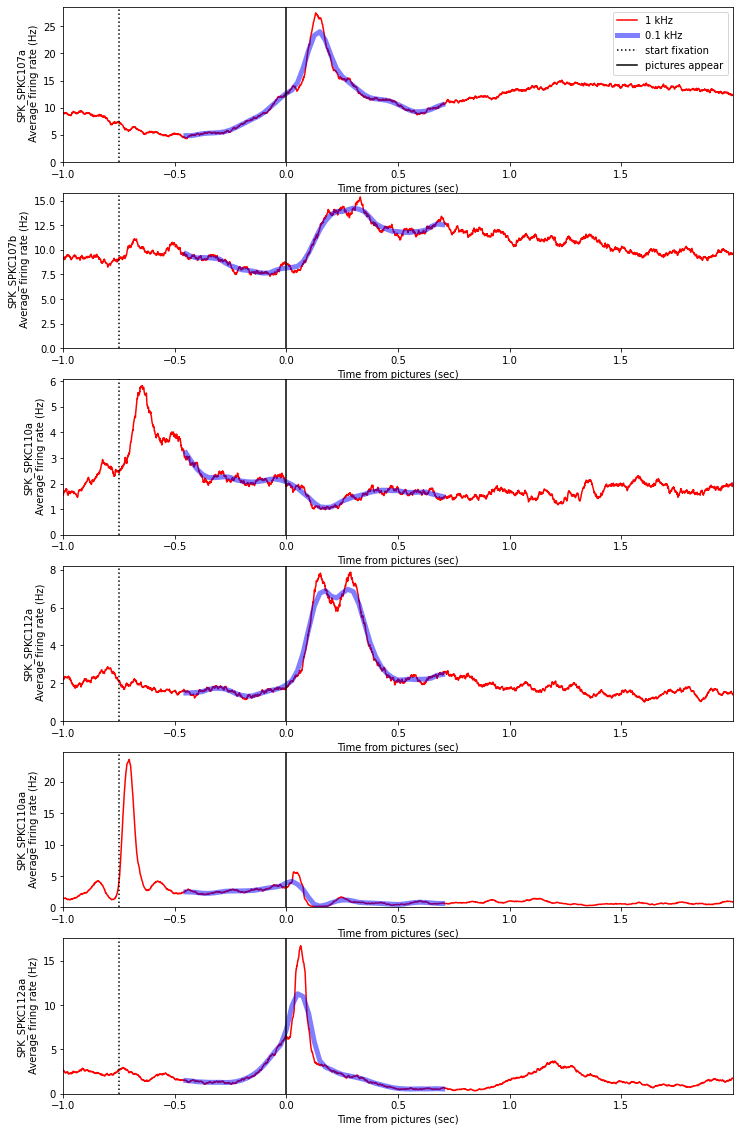

In [15]:
# show the average firing rate across all initiated trials

fig = plt.figure(figsize=(12, 20))
for u in range(nunits):
    ax = fig.add_subplot(nunits, 1, u + 1)
    ax.plot(ts_chopped, 
            np.mean(1000 * spk_fr_chopped[keep_trials, :, u], axis=0), 
            c="r")
    ax.plot(ts_100ms, 
            np.mean(1000 * spk_fr_100ms[keep_trials, :, u], axis=0),
            c="b", linewidth=5, alpha=0.5)
    
    Y = ax.get_ylim()
    new_Y = (0, Y[1])
    ax.plot(np.array([-.75, -.75]), new_Y, c="k", linestyle=":")
    ax.plot(np.array([0, 0]), new_Y, c="k")
    ax.set_ylim(new_Y)
    ax.set_xlim(ts_chopped[[0, -1]])
    
    if u == 0:
        ax.legend(["1 kHz", "0.1 kHz", "start fixation", 
                   "pictures appear"])
        
    ax.set_xlabel("Time from pictures (sec)")
    ax.set_ylabel(spk_meta.ID[u] + "\n Average firing rate (Hz)")

## Bandpass and chop LFP 

We typically look at local field potential magnitude and phase split into these frequency bands:

- $\delta$: 2 - 4 Hz
- $\theta$: 4 - 8 Hz
- $\alpha$: 8 - 12 Hz
- $\beta$: 12 - 30 Hz
- $\gamma$: 30 - 60 Hz
- high $\gamma$: 70 - 200 Hz

(after notch filtering at multiples of 60 Hz).

Loading all of these channels before chopping at sync points is very slow, and can exceed the memory capacity on my laptop. Instead, I process each channel separately (submitting bands as parallel threads using `ThreadPoolExecutor`)and just spit out the chopped array:

    output : 3D np array
        event_sync_points x time_around_event x neurons
        

In [16]:
%%time
# use the same sync points and time window as spikes
mag_chopped, phs_chopped, _, lfp_meta = \
    brain.process_raw_lfp(lfp_fname, 
                          sync_pictures_ts, 
                          time_window, 
                          fun_channels,
                          nthreads=2)

# I cut the processing time for this function in ~half by parallelizing 
# (vs. doing bands serially). My laptop only has 2 cores, and I'm 
# guessing this could run much faster on a better machine!


working on band pass...FP107
working on band pass...FP110
working on band pass...FP112
CPU times: user 2min 23s, sys: 23 s, total: 2min 46s
Wall time: 1min 30s


In [17]:
lfp_meta

,ID
0,FP107
1,FP110
2,FP112


In [18]:
# this is a good intermediate point to save
lfpbands_fname = pjoin(out_dir, session + "_lfp_chopped.npz")
np.savez(lfpbands_fname, ts_chopped=ts_chopped, 
         mag_chopped=mag_chopped,
         phs_chopped=phs_chopped,
         lfp_meta=lfp_meta)


To visualize the filtered bands, let's also load in the notch-filtered broadband LFP signal

In [19]:
broadband_chopped, _, _, _ = brain.process_raw_lfp(lfp_fname, 
                                                   sync_pictures_ts, 
                                                   time_window, 
                                                   fun_channels,
                                                   broadband=1)


working on band pass...FP107
working on band pass...FP110
working on band pass...FP112


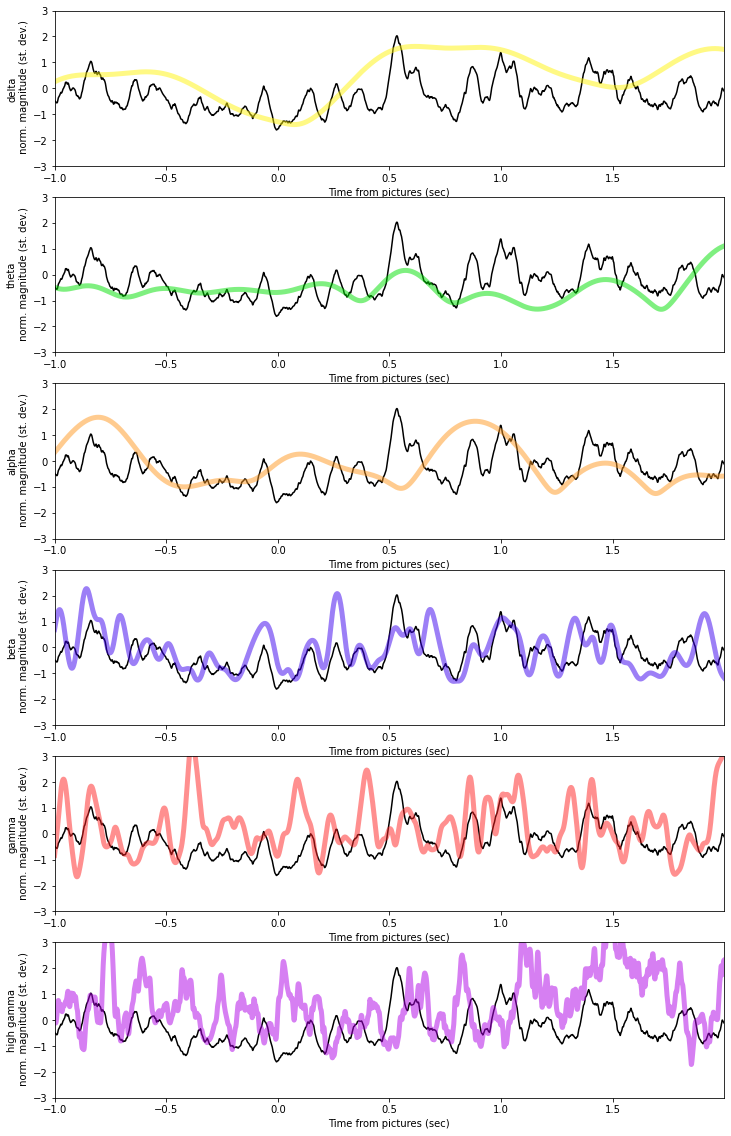

In [20]:
# overlay broadband signal with each band for a sample trial and channel
nbands = len(mag_chopped)
nchannels = len(fun_channels)
band_names = ["delta", "theta", "alpha", 
              "beta", "gamma", "high gamma"]
band_colors = ["#fff40b", "#00e103", "#ff9921", 
               "#3a00ef", "#ff2121", "#af00e7"]

sample_trial = np.random.choice(ntrials)
sample_channel = np.random.choice(len(fun_channels))

fig = plt.figure(figsize=(12, 20))
for b in range(nbands):
    ax = fig.add_subplot(nbands, 1, b + 1)
    ax.plot(ts_chopped, 
            broadband_chopped[0][sample_trial, :, sample_channel], 
            c="k")
    ax.plot(ts_chopped, 
            mag_chopped[b][sample_trial, :, sample_channel], 
            c=band_colors[b], linewidth=5, alpha=0.5)
    
    ax.set_xlabel("Time from pictures (sec)")
    ax.set_ylabel(band_names[b] + "\n norm. magnitude (st. dev.)")
    
    ax.set_xlim(ts_chopped[[0, -1]])
    ax.set_ylim((-3, 3))

We can downsample to match the spike data:

In [21]:
# let's look at the theta band, smoothed in 200 ms windows overlapping 
# by 75% (default), limited to (-1, 0.5) sec around the event

time_window_mini = (-1, 0.5)  # in sec
window = 0.2 # in sec

ts_200ms, theta_mag_200ms = brain.sliding_avg(mag_chopped[1], 
                                       ts_chopped, 
                                       time_window_mini,
                                       window)

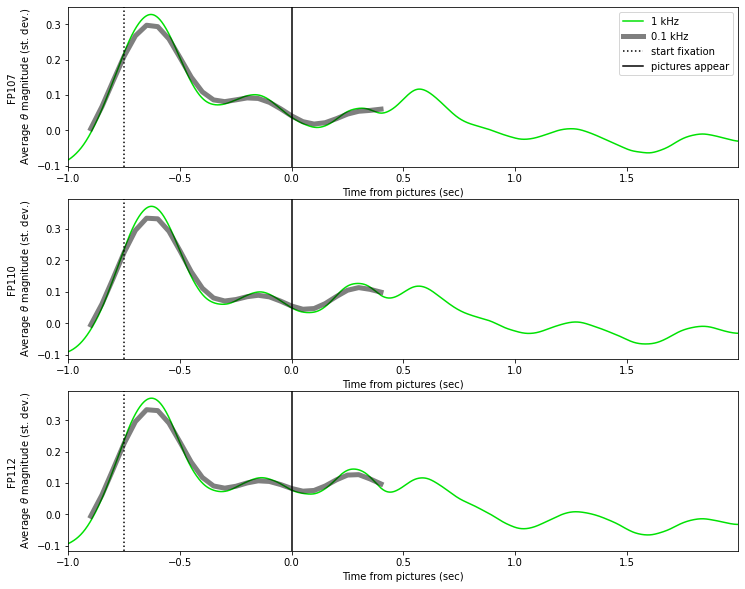

In [22]:
# show the average theta band across all initiated trials

fig = plt.figure(figsize=(12, 10))
for c in range(nchannels):
    ax = fig.add_subplot(nchannels, 1, c + 1)
    ax.plot(ts_chopped, 
            np.mean(mag_chopped[1][keep_trials, :, c], axis=0), 
            c="#00e103")
    ax.plot(ts_200ms, 
            np.mean(theta_mag_200ms[keep_trials, :, c], axis=0),
            c="k", linewidth=5, alpha=0.5)
    
    Y = ax.get_ylim()
    new_Y = Y#(0, Y[1])
    ax.plot(np.array([-.75, -.75]), new_Y, c="k", linestyle=":")
    ax.plot(np.array([0, 0]), new_Y, c="k")
    ax.set_ylim(new_Y)
    ax.set_xlim(ts_chopped[[0, -1]])
    
    if c == 0:
        ax.legend(["1 kHz", "0.1 kHz", "start fixation", 
                   "pictures appear"])
        
    ax.set_xlabel("Time from pictures (sec)")
    ax.set_ylabel(lfp_meta.ID[c] + "\n Average " + \
                  r"$\theta$" +" magnitude (st. dev.)")

^^ Cool science detour: we actually see in increase in theta magnitude during the preparation period (start of fixation, dashed line) before the pictures even show up on the screen. 

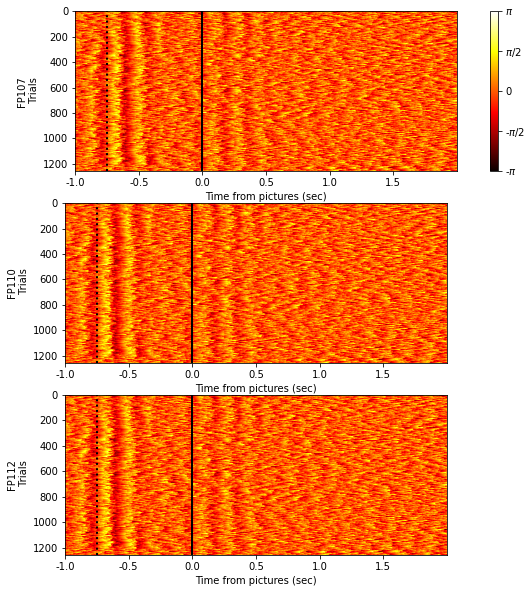

In [23]:
fig = plt.figure(figsize=(12, 10))
for c in range(nchannels):
    ax = fig.add_subplot(nchannels, 1, c + 1)
    ph = ax.imshow(phs_chopped[1][keep_trials, :, c], 
                   cmap="hot", vmin=-3.14, vmax=3.14)
    
    ax.axvline(x=250, color="k", linestyle=":", linewidth=2)
    ax.axvline(x=1000, color="k", linewidth=2)
    
    ax.set_xticks(np.arange(0, 3000, 500))
    ax.set_xticklabels(ts_chopped[np.arange(0, 3000, 500)].round(2))
    ax.set_xlabel("Time from pictures (sec)")
    ax.set_ylabel(lfp_meta.ID[c] + "\n Trials")
    
    if c == 0:
        cbar = plt.colorbar(ph)
        cbar.ax.set_yticks(np.arange(-3.14, 3.16, 3.14/2))
        cbar.ax.set_yticklabels(
            [r"-$\pi$", r"-$\pi/2$", "0", r"$\pi/2$", r"$\pi$"])

In regions like the orbitofrontal cortex and hippocampus we see a strong phase reset in the theta band. A post-doc in my lab showed that [disrupting this theta phase reset with stimulation dramatically impairs animals' performance](https://doi.org/10.1016/j.neuron.2020.02.003) if they have to learn new picture/juice associations. 

# Comparison to matlab outputs